# Tutorial notebook for predicting a missing component in a regularly varying random vector 

Implements and illustrates an example and associated method  suggested in 

    * Huet, N., Clémençon, S., & Sabourin, A. (2023). On regression in extreme regions. arXiv preprint arXiv:2303.03084.

    * Aghbalou, A., Bertail, P., Portier, F., & Sabourin, A. (2024). Cross-validation on extreme regions. Extremes, 27(4), 505-555.

## Table of Contents
* [Preliminary manipulations](#Preliminary)
* [Data generation](#Data_generation)
* [Transforming the target](#TargetTransform)
    * [Option 1: Linear transform](#TargetTransform1)
    * [Option 2: Nonlinear transform](#TargetTransform2)
* [Choice of k, Episode 1.](#Choice_k_1)
* [Learning, prediction, evaluation](#Learning)
* [Choice of k: Episode 2, cross-validation](#Choice_k_2)

## Preliminary manipulations <a class="anchor" id="Preliminary"></a>

In [1]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
# #from sklearn.base import clone
from copy import deepcopy
import MLExtreme as mlx

Choose a norm function according to which 'extreme' covariates will be
selected. Change `norm_order` to 1, 3, ... for variants.

**N.B.** `np.inf` is only applicable to the linear transform below, not the
nonlinear  transform

In [2]:
# Norm function: L2 norm. 
norm_order = 2


def norm_func(x):
    return np.linalg.norm(x, ord=norm_order, axis=1)

## Data generation <a id="Data_generation"></a>

Multivariate regularly varying (Heavy-tailed) samples are
generated. The limit angular measure (in the tail) is a Dirichlet
Mixture distribution with parameters Mu,wei,lnu defined below.  For
more details about dirichlet mixture, see e.g. the R pacakge BMAmevt
https://cran.r-project.org/web/packages/BMAmevt/

In [3]:
# Data generation
np.random.seed(42)
n = int(4 * 10**4)
Dim = 2
k = 2
alpha = 4.1  # so that standard error estimators are consistent
Mu0 = np.array([[0.1, 0.7, 0.2], [0.2, 0.1, 0.7]])
wei0 = np.ones(2)
Mu, wei = mlx.normalize_param_dirimix(Mu0, wei0)
lnu = np.log(10 / np.min(Mu, axis=1))
# Define  adversarial bulk angular measure, see function gen_rv_dirimix
Mu_bulk = np.array([[0.7, 0.15, 0.15], [0.15, 0.25, 0.6]])

XZ = mlx.gen_rv_dirimix(alpha, Mu, wei, lnu, scale_weight_noise=1.5,
                        index_weight_noise=2*alpha, Mu_bulk=Mu_bulk,
                        size=n)
X = XZ[:, :-1]
z = XZ[:, -1]

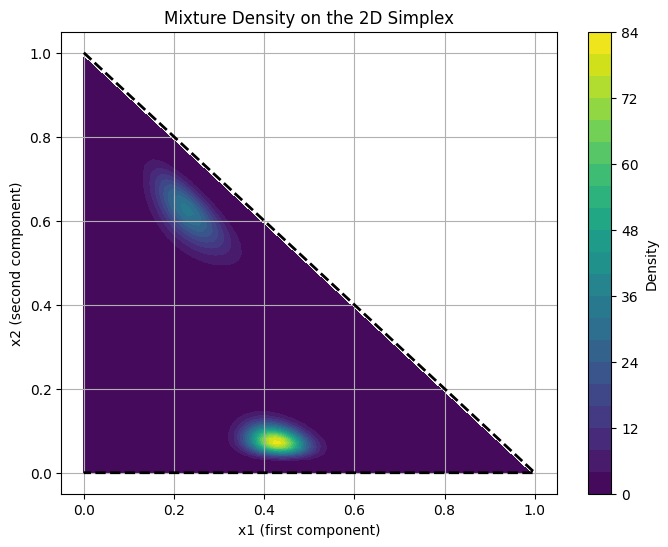

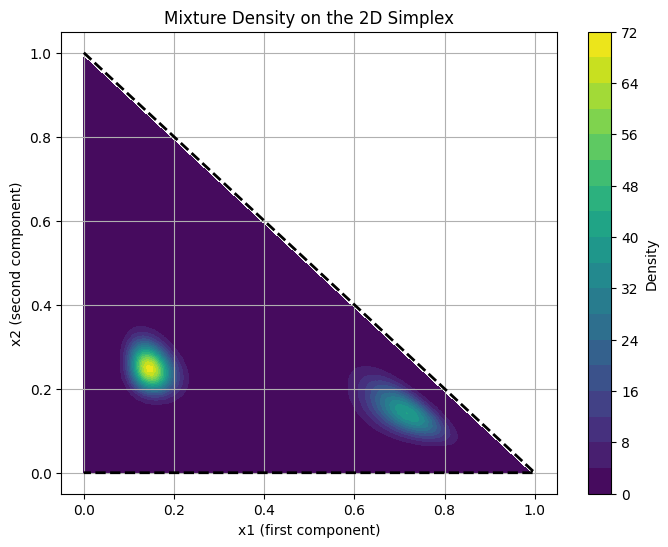

In [4]:
# ## plot limit angular measure and bulk angular measure
mlx.plot_pdf_dirimix_3D(Mu, wei, lnu, n_points=100)
    
mlx.plot_pdf_dirimix_3D(Mu_bulk, wei, lnu, n_points=100)

## Transforming the target <a class="anchor" id="TargetTransform"></a>

### Option 1: Linear transform  <a class="anchor" id="TargetTransform1"></a>
Learn a prediction model for a linear
tranform of the target, y = Target / ||X||.  appropriate when
Target / ||X|| is bounded or at least not clearly heavy tailed

In [5]:
y1 = mlx.transform_target_lin(z, X, norm_func)

# check that inverse transform gives back the right vector
z1 = mlx.inv_transform_target_lin(y1, X, norm_func)
np.sum((z1 - z)**2)
# OK

np.float64(2.9581946908047675e-29)

### Option 2:  Nonlinear transformation <a id="TargetTransform2"></a>

 y = z / (||(x,z) ||) where z is the original target, and x the
covariate.

Appropriate when z/||x|| may not be considered bounded.  If ||.|| is
the L_q norm, the inverse transform is:
z = y/ (1 - y**q)**(1/q) * || x ||

**N.B.** The infinite norm is not appropriate here, only L_q norms
are, with q in [1, inf)

In [6]:
y2 = mlx.transform_target_nonlin(z, X, 2)

# test
z2 = mlx.inv_transform_target_nonlin(y2, X, 2)
np.sum((z2 - z)**2) # OK

np.float64(2.1563789215163377e-27)

Theoretical analysis in Huet et al. requires a bounded
target. Reasonable conjecture is that results are valid with
subgaussian (~ not heavy-tailed) target. Let's check this on y1,y2:

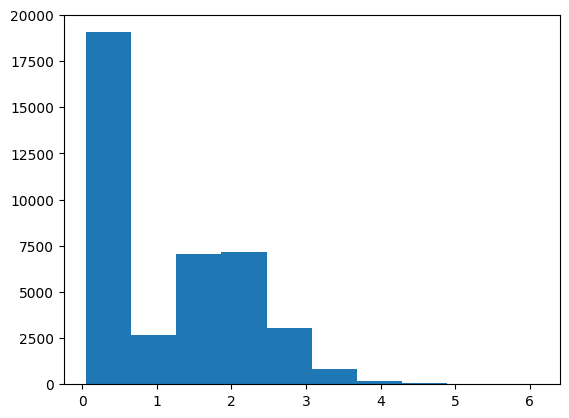

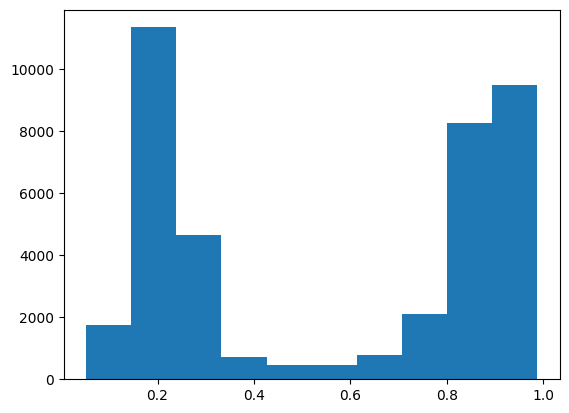

In [7]:
# boundedness assumption for y1?
plt.hist(y1)
plt.show()
# There is no clear visual evidence against the assumption that y1 is bounded. 

# what about y2?
plt.hist(y2)
plt.show()
# as expected (by construction),  y2 is automatically  strictly comprised in [0,1]

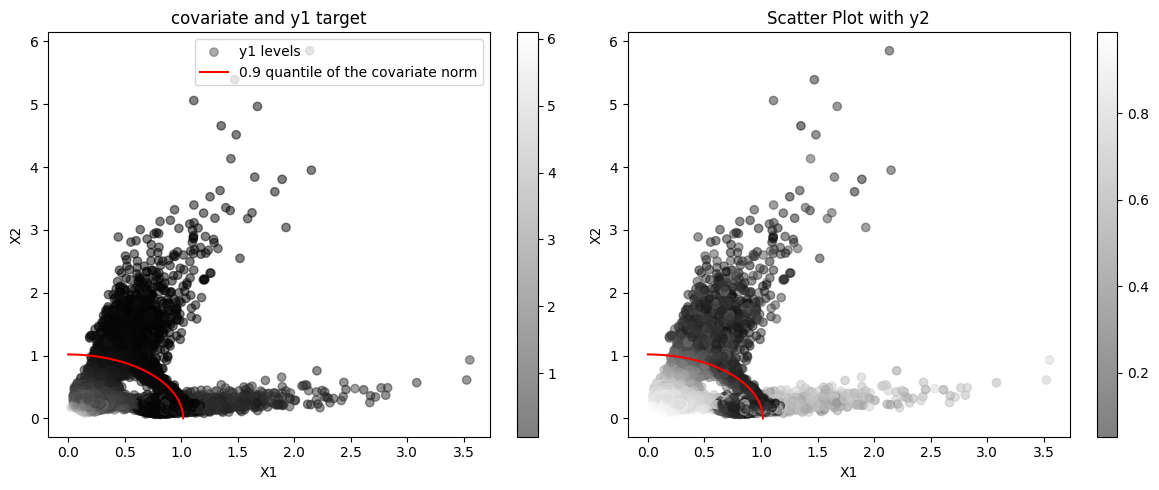

In [8]:
# Vizualisation of  y1 / y2 versus x.
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
reshape=1
scatter1 = axes[0].scatter(X[:, 0]**(reshape), X[:, 1]**(reshape), c=y1, cmap='gray', alpha=0.5, label="y1 levels")
axes[0].set_title('covariate and y1 target')
axes[0].set_xlabel('X1')
axes[0].set_ylabel('X2')
scatter2 = axes[1].scatter(X[:, 0]**(reshape), X[:, 1]**(reshape), c=y2, cmap='gray', alpha=0.5, label = "y2 levels")
r_threshold = np.quantile(norm_func(X**(reshape )), 1- 0.1)
grid = np.linspace(0, np.pi/2,num=100).reshape(-1,1)
sphere = np.hstack((np.cos(grid),np.sin(grid)))
threshold = np.quantile(r_threshold,1- 0.1)*sphere
axes[0].plot(threshold[:,0], threshold[:,1],c='red', label="0.9 quantile of the covariate norm")
axes[1].plot(threshold[:,0], threshold[:,1],c='red')
axes[1].set_title('Scatter Plot with y2')
axes[1].set_xlabel('X1')
axes[1].set_ylabel('X2')
axes[0].legend()
fig.colorbar(scatter1, ax=axes[0])
fig.colorbar(scatter2, ax=axes[1])
plt.tight_layout()
plt.show()
# similar pattern


# ### Train/test split: here (simulated data) half/half

# for y1: Splitting the data into training and test sets
split = 0.5
n_train = n * (1-split)
n_test = n * split
X_train, X_test, y_train1, y_test1 = train_test_split(X, y1,
                                                      test_size=split,
                                                      random_state=1)
# for y2: Splitting the data into training and test sets (same splits)
_ , _ , y_train2, y_test2 = train_test_split(X, y2,
                                             test_size=split,
                                             random_state=1)
# idem without transformation 
_ , _ , z_train, z_test = train_test_split(X, z,
                                           test_size=split,
                                           random_state=1)

## Choice of k, Episode 1. <a class="anchor" id="Choice_k_1"></a>

Rule-of-thumb selection of k based on independence tests radius / rest distance covariance, see notebook `supervised_regression' for details 

(For adaptive choice of k_train by cross-validation, see Episode 2 below)

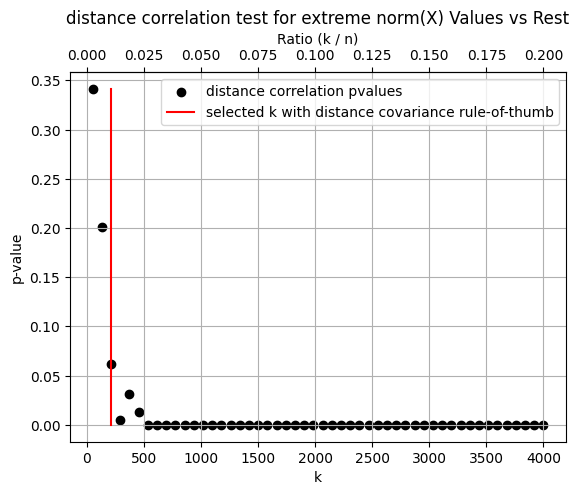

model1: maximum admissible k from the rule-of-thumb: 211
model1: maximum admissible ratio of extremes from the rule-of-thumb: 0.011


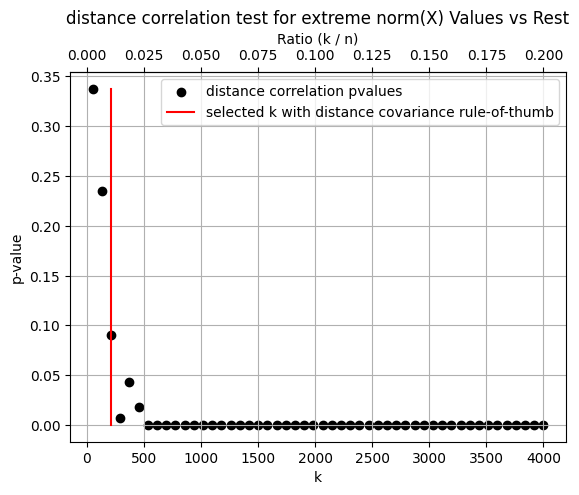

model2: maximum admissible k from the rule-of-thumb: 211
model2: maximum admissible ratio of extremes from the rule-of-thumb: 0.011


In [9]:
ratios = np.linspace(50/n_train, 0.2, num=50)
pvalues, ratio_max = mlx.test_indep_radius_rest(X_train, y_train1, ratios,
                                                norm_func)
# plot

mlx.plot_indep_radius_rest(pvalues, ratios, ratio_max, n_train)
# k ~ 2000 maximum on this example.
k_max = int(ratio_max * n_train)
print(f'model1: maximum admissible k from the rule-of-thumb: {k_max}')
print(f'model1: maximum admissible ratio of extremes from the rule-of-thumb: { mlx.round_signif(ratio_max, 2)}')

pvalues2, ratio_max2 = mlx.test_indep_radius_rest(X_train, y_train2, ratios,
                                                  norm_func)

# plot
mlx.plot_indep_radius_rest(pvalues2, ratios, ratio_max2, n_train)
# k ~ 2000 maximum on this example.
k_max2 = int(ratio_max2 * n_train)
print(f'model2: maximum admissible k from the rule-of-thumb: {k_max2}')
print(f'model2: maximum admissible ratio of extremes from the rule-of-thumb: \
{ mlx.round_signif(ratio_max2, 2)}')

# NB: the  results with y1 and y2 are similar indeed  y2 is a non-decreasing transform of y1. 

In [10]:
# Set training and prediction ratios accordingly:
ratio_train = np.minimum(ratio_max2, ratio_max) * 4/5
ratio_test = np.minimum(ratio_max2, ratio_max) / 2   # higher quantile than training quantile: 
norm_X_train = norm_func(X_train)
thresh_predict = np.quantile(norm_X_train, 1-ratio_test)
thresh_train = np.quantile(norm_X_train, 1-ratio_train)
k_train = int(ratio_train * n_train)
print(f'rule-of-thumb selected k_train: {k_train}')




rule-of-thumb selected k_train: 168


## Learning, prediction, evaluation <a class="anchor" id="Learning"></a>

Choice of an off-the-shelf regression algorithm
see https://scikit-learn.org/stable/supervised_learning.html

In [11]:
# Pick   classifier models in sklearn, previously imported
model = LinearRegression()
task = 'regression'
# Initialize Regressor class instances with deep copies of the model to avoid cross-referencing issues.
regressor1 = mlx.xcovPredictor(task, model, norm_func)
regressor2 = mlx.xcovPredictor(task, model, norm_func)
# Use the original model directly for a naive approach.
naive = deepcopy(model)

# Training the models
thresh_train, _, X_train_extreme = regressor1.fit(X_train, y_train1, k=k_train)
_,_,_ = regressor2.fit(X_train, y_train2, k=k_train)
naive.fit(X_train, z_train)

# Prediction on the test data
y_pred_extreme1,  X_test_extreme, mask_test = regressor1.predict(
                                                X_test, thresh_predict)
y_pred_extreme2, _, _  = regressor2.predict(X_test, thresh_predict)
z_pred_naive = naive.predict(X_test)
z_pred_naive_extreme = z_pred_naive[mask_test]

# trained (estimated) parameters:
print("trained parameters of models 1,2, naive: ")
print(regressor1.model.coef_, regressor1.model.intercept_)
print(regressor2.model.coef_, regressor2.model.intercept_)
print(naive.coef_, naive.intercept_)


# # Evaluation of Mean Squared Error (MSE)
y_test_extreme1 = y_test1[mask_test]  # Filter test labels based on mask
y_test_extreme2 = y_test2[mask_test]  # Filter test labels based on mask
MSE1 = mean_squared_error(y_test_extreme1, y_pred_extreme1)
MSE2 = mean_squared_error(y_test_extreme2, y_pred_extreme2)
print(f'MSE1 - transformed target 1: {MSE1:.4f}')
print(f'MSE2 - transformed target 2: {MSE2:.4f}')
# N.B. results are not comparable becasue the two targets are different

trained parameters of models 1,2, naive: 
[-0.26856395 -1.285764  ] 1.527893598479969
[-0.1383316  -0.75169961] 0.9747787714164023
[-0.45162284  0.04895922] 0.7154307064432933
MSE1 - transformed target 1: 0.0161
MSE2 - transformed target 2: 0.0055


Display regression results

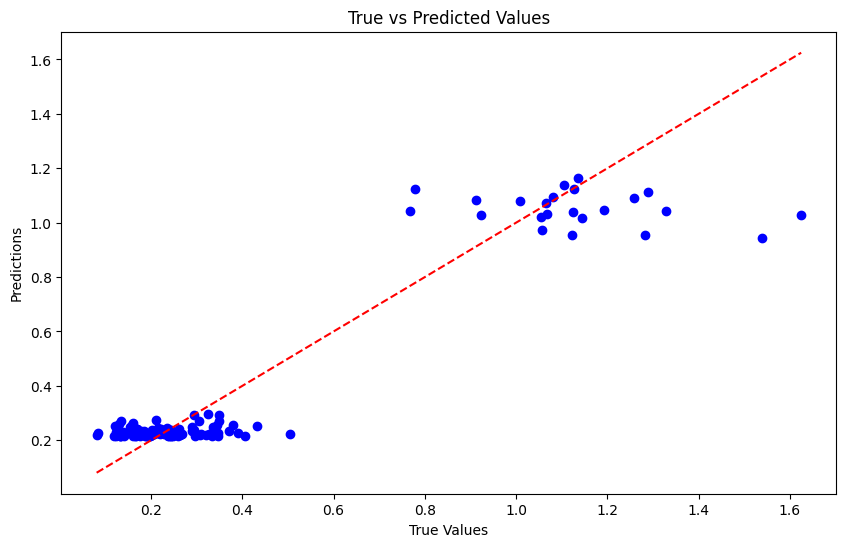

In [12]:
mlx.plot_predictions(y_test_extreme1, y_pred_extreme1)

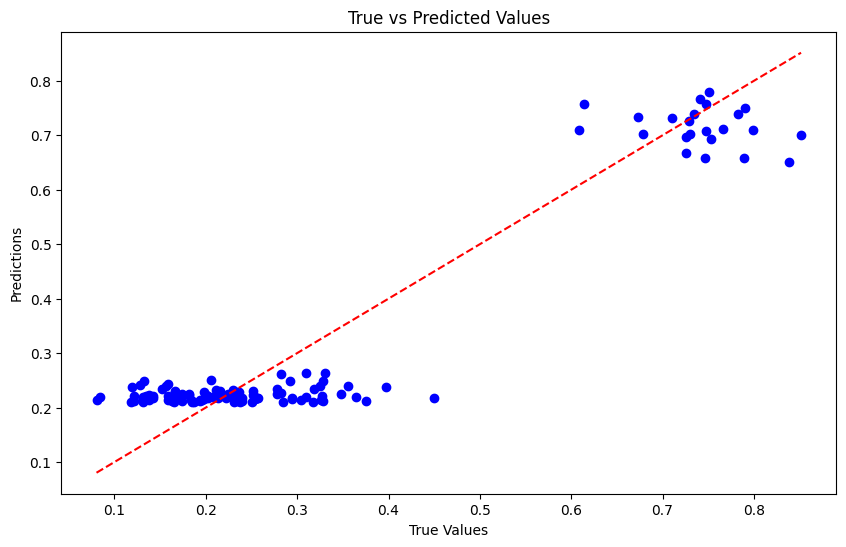

In [13]:
mlx.plot_predictions(y_test_extreme2, y_pred_extreme2)

# %%[markdown]
# ### How about performance in terms of the original target?

In [14]:
# back to original scale:

z_test_extreme = z_test[mask_test]
                         
z_pred_extreme1 = mlx.inv_transform_target_lin(y_pred_extreme1, X_test_extreme,
                                               norm_func)
z_pred_extreme2 = mlx.inv_transform_target_nonlin(y_pred_extreme2,
                                                  X_test_extreme,
                                                  norm_order)

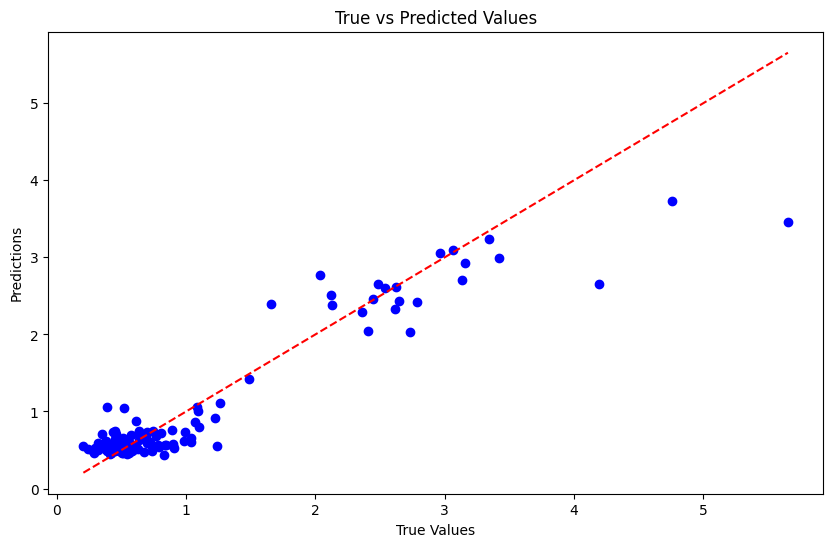

In [15]:
# MLX predictions method 1 
mlx.plot_predictions(z_test_extreme, z_pred_extreme1)

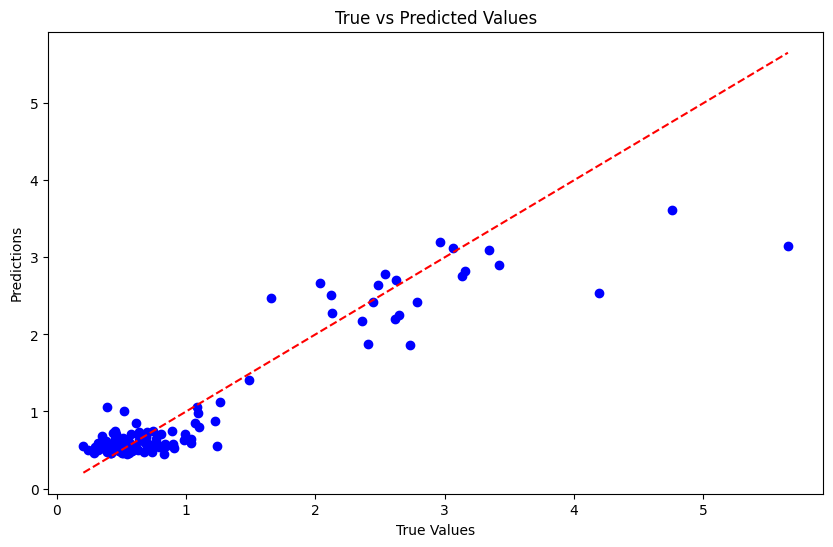

In [16]:
# MLX predictions method 2
mlx.plot_predictions(z_test_extreme, z_pred_extreme2)

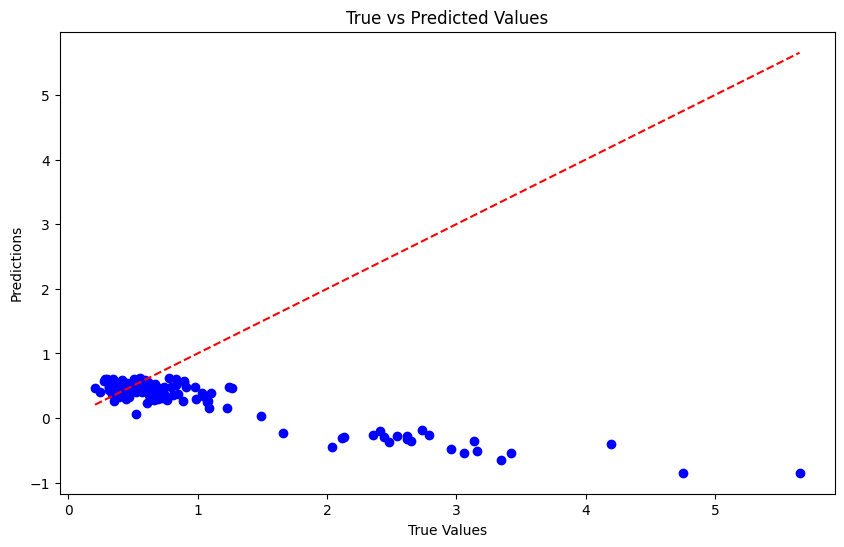

In [17]:
# naive predictions
mlx.plot_predictions(z_test_extreme, z_pred_naive_extreme)

In [18]:
# MSE comparison, raw target 
MSE_meth1_z = mean_squared_error(z_test_extreme, z_pred_extreme1)
print(f'MSE original target with linear method 1: {MSE_meth1_z:.4f}')
# 0.90-Confidence interval half-widths:
hw_1 = 1.64 * np.std((z_test_extreme - z_pred_extreme1)**2) / \
    np.sqrt(len(z_test_extreme))
print(f' half-width CI (alpha=0.9) for MSE (original target), method 1 : \
{mlx.round_signif(hw_1, 2)}')

MSE_meth2_z = mean_squared_error(z_test_extreme, z_pred_extreme2)
print(f'MSE original target  with nonlinear method 2: {MSE_meth2_z:.4f}')
hw_2 = 1.64 * np.std((z_test_extreme - z_pred_extreme2)**2) / \
    np.sqrt(len(z_test_extreme))
print(f' half-width CI for MSE (original target), method 2 : \
{mlx.round_signif(hw_2, 2)}')


MSE_naive_z = mean_squared_error(z_test_extreme, z_pred_naive_extreme)
print(f'MSE for naive sklearn model trained on full data: {MSE_naive_z:.4f}')
hw_naive = 1.64 * np.std((z_test_extreme - z_pred_naive_extreme)**2) / \
    np.sqrt(len(z_test_extreme))
print(f' half-width CI for MSE (original target), naive method : \
{mlx.round_signif(hw_naive, 2)}')

MSE original target with linear method 1: 0.1297
 half-width CI (alpha=0.9) for MSE (original target), method 1 : 0.075
MSE original target  with nonlinear method 2: 0.1546
 half-width CI for MSE (original target), method 2 : 0.096
MSE for naive sklearn model trained on full data: 2.4602
 half-width CI for MSE (original target), naive method : 0.92


 **Results:** nsignificantly better performance of method 1 over method
 2 for rescaling the target. Siginificant improvement over the naive
 method.

## Choice of k: Episode 2, cross-validation <a class="anchor" id="Choice_k_2"></a>

 `thresh_predict` is kept fixed as above (downstream task) `but thresh_train`
will be chosen by cross-validation

In [19]:
# Set the range of candidates training threshold, using X_train only.
ratio_train_vect = np.geomspace(0.01, 0.6, num=15)
k_train_vect = (n_train * ratio_train_vect).astype(int)
thresh_train_vect = np.array([np.quantile(norm_X_train, 1 - r)
                              for r in ratio_train_vect])
# cross-validation on the training set. 
kscores1 = []
kscores_sd1 = []
kscores2 = []
kscores_sd2 = []
count = 1
# cv-loop (time consuming)
for thresh in thresh_train_vect:
    mean_scores, sd_mean_scores, _ = regressor1.cross_validate(
        X_train, y_train1, thresh_train=thresh, thresh_predict=thresh_predict,
        scoring=mean_squared_error,
        random_state=k*7)
    kscores_sd1.append(sd_mean_scores)
    kscores1.append(mean_scores)
    mean_scores, sd_mean_scores, _ = regressor2.cross_validate(
        X_train, y_train2, thresh_train=thresh, thresh_predict=thresh_predict,
        scoring=mean_squared_error,
        random_state=k*7)
    kscores_sd2.append(sd_mean_scores)
    kscores2.append(mean_scores)

kscores1 = np.array(kscores1)
kscores_sd1 = np.array(kscores_sd1)
kscores2 = np.array(kscores2)
kscores_sd2 = np.array(kscores_sd2)

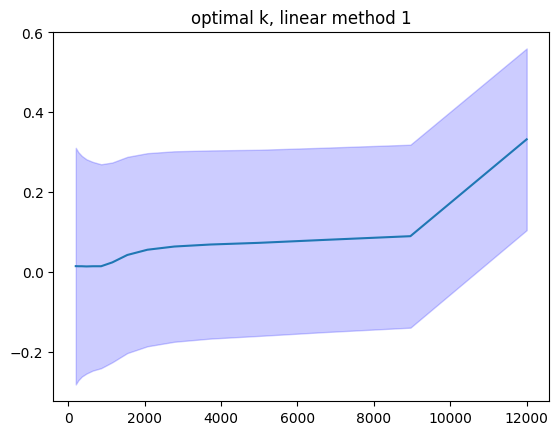

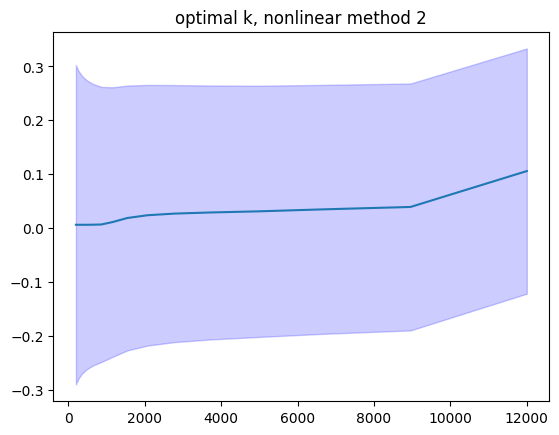

In [20]:
# plot the results
plt.plot(k_train_vect, kscores1)
plt.fill_between(k_train_vect, kscores1 +  kscores_sd1,
                 kscores1 -  kscores_sd1, color='blue', alpha=0.2)
plt.title("optimal k, linear method 1") 
plt.show()

plt.plot(k_train_vect, kscores2)
plt.fill_between(k_train_vect, kscores2 +  kscores_sd2,
                 kscores2 -  kscores_sd2, color='blue', alpha=0.2)
plt.title("optimal k, nonlinear method 2")
plt.show()

In [21]:
# Define new values for  k_train.
i_opt1 = np.argmin(kscores1)
k_opt1 = k_train_vect[i_opt1]
print(f'optimal k linear transfom method 1: {k_opt1}')
i_opt2 = np.argmin(kscores2)
k_opt2 = k_train_vect[i_opt2]
print(f'optimal k linear transfom method 2: {k_opt2}')

print(f'rule-of-thumb k : {int(n_train * ratio_max * 4/5)}')

optimal k linear transfom method 1: 480
optimal k linear transfom method 2: 480
rule-of-thumb k : 168


Methods 1 and 2: retrain (on training set) and evaluate (on test set)
using  optimal k selected by CV 

In [22]:
regressor1.fit(X_train, y_train1, k=k_opt1)
regressor2.fit(X_train, y_train2, k=k_opt2)

y_pred_extreme1_cv, _, _ = regressor1.predict(X_test, thresh_predict)
y_pred_extreme2_cv, _, _ = regressor2.predict(X_test, thresh_predict)

MSE1_cv = mean_squared_error(y_test_extreme1, y_pred_extreme1_cv)
MSE2_cv = mean_squared_error(y_test_extreme2, y_pred_extreme2_cv)
print(f'MSE transformed scale linear method1 after cv : {MSE1_cv:.6f}')
print(f'MSE transformed scale linear method1 before cv : {MSE1:.6f}')
print(f'MSE transformed scale nonlinear method2 after cv: {MSE2_cv:.6f}')
print(f'MSE transformed scale nonlinear method2 before cv: {MSE2:.6f}')

MSE transformed scale linear method1 after cv : 0.015542
MSE transformed scale linear method1 before cv : 0.016078
MSE transformed scale nonlinear method2 after cv: 0.005451
MSE transformed scale nonlinear method2 before cv: 0.005502


The results are indistinguishable before and after
cross-validation choice of k, indicating that the model's
performance is consistent across different 'reasonable' choices of
k_train.